# COVID data LSTM 예측

* 안 예쁘게 나왔다. 뭔가 이상하군!
    - 모양 자체는 비슷한데, 예측 기간을 25일로 잡아서 뒤로 갈수록 더 주기적인 패턴으로 나온 것 같다.
    - 그래프 색깔을 다르게 그리자.

In [ ]:
# module import
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# path
root_path = "/content/drive/My Drive/TOY/Data Analysis/Kaggle/novel-COVID"
data_path = f"{root_path}/data"

In [ ]:
# load data
df_raw = pd.read_csv(f"{data_path}/covid_19_data.csv")
df = df_raw.copy()

# _1_. 데이터 정제

- 정제 후 `copy`

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53927 entries, 0 to 53926
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SNo              53927 non-null  int64  
 1   ObservationDate  53927 non-null  object 
 2   Province/State   32870 non-null  object 
 3   Country/Region   53927 non-null  object 
 4   Last Update      53927 non-null  object 
 5   Confirmed        53927 non-null  float64
 6   Deaths           53927 non-null  float64
 7   Recovered        53927 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 3.3+ MB


In [ ]:
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [ ]:
df.tail()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
53922,53923,06/30/2020,Zacatecas,Mexico,2020-07-01 04:33:52,908.0,96.0,626.0
53923,53924,06/30/2020,Zakarpattia Oblast,Ukraine,2020-07-01 04:33:52,2889.0,91.0,943.0
53924,53925,06/30/2020,Zaporizhia Oblast,Ukraine,2020-07-01 04:33:52,572.0,17.0,418.0
53925,53926,06/30/2020,Zhejiang,Mainland China,2020-07-01 04:33:52,1269.0,1.0,1267.0
53926,53927,06/30/2020,Zhytomyr Oblast,Ukraine,2020-07-01 04:33:52,1404.0,29.0,746.0


In [ ]:
# 필요 없는 열 제거
df.drop(columns=['SNo'], axis=1, inplace=True)
df.head()

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [ ]:
# 결측치 제거
print(df.isnull().sum())
df.dropna(inplace=True)
print(df.isnull().sum())
df.head()

ObservationDate        0
Province/State     21057
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
dtype: int64
ObservationDate    0
Province/State     0
Country/Region     0
Last Update        0
Confirmed          0
Deaths             0
Recovered          0
dtype: int64


,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [ ]:
# 그룹핑 통해 일자별 숫자 구하기
df = df.groupby(by=['ObservationDate']).sum()
df.head()

,Confirmed,Deaths,Recovered
ObservationDate,,,
01/22/2020,555.0,17.0,28.0
01/23/2020,653.0,18.0,30.0
01/24/2020,941.0,26.0,36.0
01/25/2020,1438.0,42.0,39.0
01/26/2020,2118.0,56.0,52.0


In [ ]:
# 누적합 해체, 일자별 날짜 구하기
df = df - df.shift(1)
df.head()

,Confirmed,Deaths,Recovered
ObservationDate,,,
01/22/2020,NaN,NaN,NaN
01/23/2020,98.0,1.0,2.0
01/24/2020,288.0,8.0,6.0
01/25/2020,497.0,16.0,3.0
01/26/2020,680.0,14.0,13.0


In [ ]:
# 결측치 제거
df.dropna(inplace=True)
df.head()

,Confirmed,Deaths,Recovered
ObservationDate,,,
01/23/2020,98.0,1.0,2.0
01/24/2020,288.0,8.0,6.0
01/25/2020,497.0,16.0,3.0
01/26/2020,680.0,14.0,13.0
01/27/2020,809.0,26.0,9.0


,Confirmed,Deaths,Recovered
ObservationDate,,,
01/23/2020,-1.213310,-1.220262,-0.928623
01/24/2020,-1.209784,-1.217588,-0.928512
01/25/2020,-1.205905,-1.214532,-0.928595
01/26/2020,-1.202508,-1.215296,-0.928317
01/27/2020,-1.200114,-1.210711,-0.928428


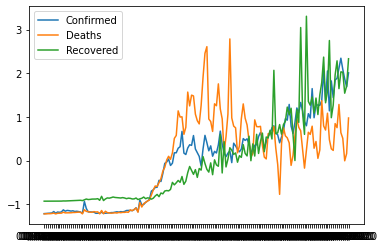

In [ ]:
# 표준화
df = (df - df.mean())/df.std()
display(df.head())

plt.plot(df['Confirmed'], label='Confirmed')
plt.plot(df['Deaths'], label='Deaths')
plt.plot(df['Recovered'], label='Recovered')
plt.legend()
plt.show()

In [ ]:
# 복사
data = df.copy()
data.shape

(160, 3)

# _2_. LSTM 구성

In [ ]:
# train data 생성
def createTrainData(X_data, step):
    m = np.arange(len(X_data)-step)

    # np.array로 바꿔 주기: 안 그러면 나중에 KeyError난다.
    X_data = np.array(X_data)

    X, Y = [], []
    for i in m:
        x = X_data[i:i+step]
        X.append(x)
    for i in m+1:
        y = X_data[i:i+step]
        Y.append(y[-1])

    X = np.reshape(np.array(X), (len(m), step, 3))
    Y = np.reshape(np.array(Y), (len(m), 3))

    return X, Y

In [ ]:
# copy data
data_1 = data.copy()
data_1.shape

(160, 3)

In [ ]:
# params
n_step = int(input('학습 스텝 설정: '))
n_features = X_data.shape[-1]
n_hidden = int(input('FFN 은닉노드 수 설정: '))
n_output = y_data.shape[-1]

학습 스텝 설정: 10
FFN 은닉노드 수 설정: 100


In [ ]:
X_data, y_data = createTrainData(data_1, n_step)
print(f"X: {X_data.shape}, y: {y_data.shape}")

X: (150, 10, 3), y: (150, 3)


In [ ]:
# 모델 구성
x_Input = Input(batch_shape = (None, n_step, n_features))
x_Lstm = LSTM(n_hidden)(x_Input)
x_Output = Dense(n_output)(x_Lstm)

# 모델 params
LR = float(input('학습률 설정: '))
EPOCHS = int(input('학습 에폭 수 설정: '))
BATCH = int(input('배치 사이즈 설정: '))

model = Model(x_Input, x_Output)
model.compile(loss='mse', optimizer=Adam(lr=LR))
print(model.summary())

학습률 설정: 0.01
학습 에폭 수 설정: 300
배치 사이즈 설정: 50
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 3)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               41600     
_________________________________________________________________
dense (Dense)                (None, 3)                 303       
Total params: 41,903
Trainable params: 41,903
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# 모델 훈련
hist = model.fit(X_data, y_data,
                 batch_size=BATCH,
                 epochs=EPOCHS,
                 shuffle=True)

Epoch 1/300
3/3 [==============================] - 0s 10ms/step - loss: 0.5715
Epoch 2/300
3/3 [==============================] - 0s 7ms/step - loss: 0.2114
Epoch 3/300
3/3 [==============================] - 0s 7ms/step - loss: 0.1778
Epoch 4/300
3/3 [==============================] - 0s 7ms/step - loss: 0.1316
Epoch 5/300
3/3 [==============================] - 0s 7ms/step - loss: 0.1277
Epoch 6/300
3/3 [==============================] - 0s 7ms/step - loss: 0.1220
Epoch 7/300
3/3 [==============================] - 0s 7ms/step - loss: 0.1125
Epoch 8/300
3/3 [==============================] - 0s 7ms/step - loss: 0.1098
Epoch 9/300
3/3 [==============================] - 0s 7ms/step - loss: 0.1031
Epoch 10/300
3/3 [==============================] - 0s 7ms/step - loss: 0.1018
Epoch 11/300
3/3 [==============================] - 0s 11ms/step - loss: 0.0985
Epoch 12/300
3/3 [==============================] - 0s 9ms/step - loss: 0.0976
Epoch 13/300
3/3 [==============================] - 0s 8ms/

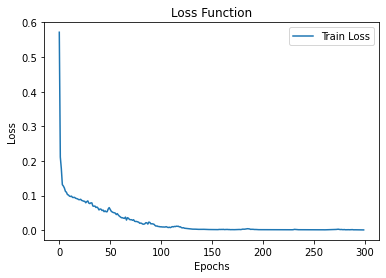

In [ ]:
# plot loss
plt.plot(hist.history['loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function')
plt.legend()
plt.show()

In [ ]:
# 예측
n_futures = int(input('예측 기간 수 설정: '))

last_data = data_1[-100:]
print(last_data.shape)

예측 기간 수 설정: 25
(100, 3)


In [ ]:
X_pred = np.copy(last_data)
print(f"예측에 활용할 데이터: {X_pred.shape}")
estimate = [X_pred[-1]]
print(estimate)

예측에 활용할 데이터: (100, 3)
[array([2.0084913, 0.9752143, 2.3315988])]


In [ ]:
# 예측
for _ in range(n_futures):
    x = X_pred[-n_step:].reshape(1, n_step, n_features)
    # print(x)
    y_hat = model.predict(x)[0]
    # print(y_hat)
    estimate.append(y_hat)
    X_pred = np.insert(X_pred, len(X_pred), y_hat, axis=0)
    print(f"{_} : {X_pred.shape}")

0 : (101, 3)
1 : (102, 3)
2 : (103, 3)
3 : (104, 3)
4 : (105, 3)
5 : (106, 3)
6 : (107, 3)
7 : (108, 3)
8 : (109, 3)
9 : (110, 3)
10 : (111, 3)
11 : (112, 3)
12 : (113, 3)
13 : (114, 3)
14 : (115, 3)
15 : (116, 3)
16 : (117, 3)
17 : (118, 3)
18 : (119, 3)
19 : (120, 3)
20 : (121, 3)
21 : (122, 3)
22 : (123, 3)
23 : (124, 3)
24 : (125, 3)


In [ ]:
estimate

[array([2.0084913, 0.9752143, 2.3315988]),
 array([2.1565735, 0.6884165, 2.5321908], dtype=float32),
 array([2.1033335, 1.2415987, 1.6361828], dtype=float32),
 array([2.572298 , 0.7808899, 2.0891864], dtype=float32),
 array([1.72885   , 0.48628342, 2.476856  ], dtype=float32),
 array([2.067026  , 0.30405843, 1.1275321 ], dtype=float32),
 array([1.7481204 , 0.04222913, 1.7370276 ], dtype=float32),
 array([1.8846846 , 0.65068525, 2.214517  ], dtype=float32),
 array([1.948285 , 0.7874849, 2.342166 ], dtype=float32),
 array([2.3223722, 1.2769281, 1.9338568], dtype=float32),
 array([2.4075058 , 0.67611504, 2.0082479 ], dtype=float32),
 array([2.0836256, 0.5939165, 2.203424 ], dtype=float32),
 array([1.9037226 , 0.09715243, 1.4185069 ], dtype=float32),
 array([1.8033168 , 0.13888858, 1.713726  ], dtype=float32),
 array([1.9471886, 0.7581835, 2.307542 ], dtype=float32),
 array([2.0585358 , 0.78665704, 2.4193902 ], dtype=float32),
 array([2.2599542, 1.192428 , 1.932968 ], dtype=float32),
 arra

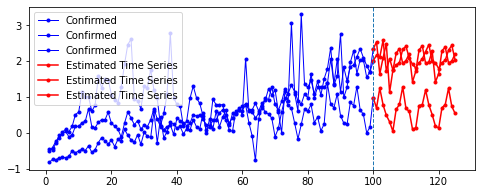

In [ ]:
# 예측 그래프 그리기
ax_prev = np.arange(1, len(last_data)+1)
ax_next = np.arange(len(last_data), len(last_data)+len(estimate))
plt.figure(figsize=(8, 3))
plt.plot(ax_prev, last_data, 'b-o', color='blue', markersize=3, label='Confirmed', linewidth=1)
plt.plot(ax_next, estimate, 'b-o', color='red', markersize=3, label='Estimated Time Series')
plt.axvline(x=ax_prev[-1], linestyle='dashed', linewidth=1)
plt.legend()
plt.show()

## 에러 기록

In [ ]:
X_data, y_data = createTrainData(data_1, n_step)
print(f"X: {X_data.shape}, Y: {y_data.shape}")

KeyError: ignored

In [ ]:
np.arange(len(data_1)-n_step)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149])

In [ ]:
for i in np.arange(len(data_1)-n_step):
    x = data_1[i:i+n_step]
    print(x, type(x))
    if i == 3:
        break

                 Confirmed    Deaths  Recovered
ObservationDate                                
01/23/2020       -1.213310 -1.220262  -0.928623
01/24/2020       -1.209784 -1.217588  -0.928512
01/25/2020       -1.205905 -1.214532  -0.928595
01/26/2020       -1.202508 -1.215296  -0.928317
01/27/2020       -1.200114 -1.210711  -0.928428
01/28/2020       -1.165926 -1.201925  -0.927401
01/29/2020       -1.204234 -1.219880  -0.928151
01/30/2020       -1.176710 -1.206127  -0.928206
01/31/2020       -1.183763 -1.204599  -0.926485
02/01/2020       -1.175912 -1.203071  -0.926957 <class 'pandas.core.frame.DataFrame'>
                 Confirmed    Deaths  Recovered
ObservationDate                                
01/24/2020       -1.209784 -1.217588  -0.928512
01/25/2020       -1.205905 -1.214532  -0.928595
01/26/2020       -1.202508 -1.215296  -0.928317
01/27/2020       -1.200114 -1.210711  -0.928428
01/28/2020       -1.165926 -1.201925  -0.927401
01/29/2020       -1.204234 -1.219880  -0.928151
01

In [ ]:
for i in np.arange(len(data_1)-n_step)+1:
    y = data_1[i:i+n_step]
    y = np.array(y)
    print(y[-1], type(y[-1]))
    if i == 3:
        break

[-1.12698769 -1.18129566 -0.92345995] <class 'numpy.ndarray'>
[-1.15770439 -1.19619449 -0.92448695] <class 'numpy.ndarray'>
[-1.14068492 -1.19543045 -0.92232193] <class 'numpy.ndarray'>


In [ ]:
# 이거 처음에 X_pred를 원본 데이터로 안 잡고 3차원으로 잡아서;;;

for _ in range(n_futures):
    x = X_pred[-n_step:].reshape(1, n_step, n_features)
    print(x)
    break

ValueError: ignored